In [6]:
# pyright: reportUnusedCallResult = none
import sys
from pathlib import Path
sys.path.insert(1, Path.cwd().parent.as_posix())

import matplotlib.pyplot as plt
import numpy as np
from numpy import typing as npt
from utils.oscilloscope import Oscilloscope
from utils.fitting import Sine

In [7]:
def read_file(idx: int) -> tuple[npt.NDArray[np.float64], npt.NDArray[np.float64], npt.NDArray[np.float64], int]:
    if idx in (51, 52, 53, 22):
        ch1_del_data = -1.024
        ch2_del_data = -1.024
    elif idx in (23, ):
        ch1_del_data = -1.024
        ch2_del_data = -0.01024
    elif idx in (24, ):
        ch1_del_data = -1.024
        ch2_del_data = -0.0256
    else:
        ch1_del_data = None
        ch2_del_data = None
    t, ch1, ch2 = Oscilloscope.LabDid.load_data(idx, dir="data", ch1_del_data=ch1_del_data, ch2_del_data=ch2_del_data)
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(t, ch1, color="C0")
    ax2.plot(t, ch2, color="C1")
    plt.savefig(f"elab/{idx}.png")
    plt.close()
    return (t, ch1, ch2, idx)


files = list(map(read_file, range(54)))
files1 = list(zip(
    [10., 50., 100., 250., 500., 750., 1e3, 75., 125., 150., 175., 200., 155., 160., 165., 170., 1.5e3, 2e3, 10e3, 50e3, 25., 5., 2., 1., 0.1, 0.01],
    files[2:22] + files[48:54]
))
files2 = list(zip(
    [0.01, 0.1, 1., 10., 25., 50., 75., 100., 125., 150., 155., 160., 165., 170., 175., 200., 250., 500., 750., 1e3, 2e3, 5e3, 10e3, 50e3, 100e3, 200e3],
    files[22:48]
))

$$\left|\frac{V_\text{out}}{V_\text{in}}\right| = \frac{1}{\sqrt{1 + \omega^2 \tau^2}}$$

In [8]:
def normal(x: npt.NDArray[np.float64], mu: float = 0, sigma: float = 1) -> npt.NDArray[np.float64]:
    return np.exp(-((x - mu) / sigma)**2 / 2) / (np.sqrt(2 * np.pi) * sigma)

def normalize(x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return x / x.sum()

# WEIGHTS = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
W_N = 3
WEIGHTS = normalize(normal(np.linspace(-1, 1, W_N * 2 + 1, dtype=np.float64), sigma=0.5))
print(WEIGHTS)

def media_mobile(ch2: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    out = []
    N = len(ch2) - 1
    for i in range(N+1):
        weights = WEIGHTS[max(0, W_N-i):W_N+1+N-i]
        weights = weights / weights.sum()
        data = ch2[max(0, i-W_N):min(i+W_N, N)+1]
        out.append(data.dot(weights))
    return np.array(out)

# plt.scatter(np.linspace(-1, 1, 2 * W_N + 1), WEIGHTS)

files1mod = [(f, (t, media_mobile(media_mobile(ch1)), media_mobile(media_mobile(ch2)), idx)) for (f, (t, ch1, ch2, idx)) in files1]
files2mod = [(f, (t, media_mobile(media_mobile(ch1)), media_mobile(media_mobile(ch2)), idx)) for (f, (t, ch1, ch2, idx)) in files2]

for (_, (t, ch1, ch2mod, idx)) in files1mod + files2mod:
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(t, ch1, color="C0")
    ax2.plot(t, ch2mod, color="C1")
    plt.savefig(f"elab/{idx}mod.png")
    plt.close()

[0.03663285 0.11128076 0.21674532 0.27068215 0.21674532 0.11128076
 0.03663285]


In [9]:
def _fit_file(freq: float, t: npt.NDArray[np.float64], ch1: npt.NDArray[np.float64], ch2: npt.NDArray[np.float64]) -> tuple[npt.NDArray[np.float64], Sine, Sine]:
    _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(t, ch1, color="C0")
    ax2.plot(t, ch2, color="C1")
    sine1 = Sine.fit(t, ch1, freq0=freq)
    sine2 = Sine.fit(t, ch2, freq0=sine1.freq)
    ax1.plot(t, sine1(t), color="C2")
    ax2.plot(t, sine2(t), color="C3")
    plt.savefig(f"elab/{idx}fit.png")
    plt.close()
    return t, sine1, sine2


files1fit = [(idx, *_fit_file(freq0, t, ch1, ch2)) for (freq0, (t, ch1, ch2, idx)) in files1]
files2fit = [(idx, *_fit_file(freq0, t, ch1, ch2)) for (freq0, (t, ch1, ch2, idx)) in files2]

# Prima parte

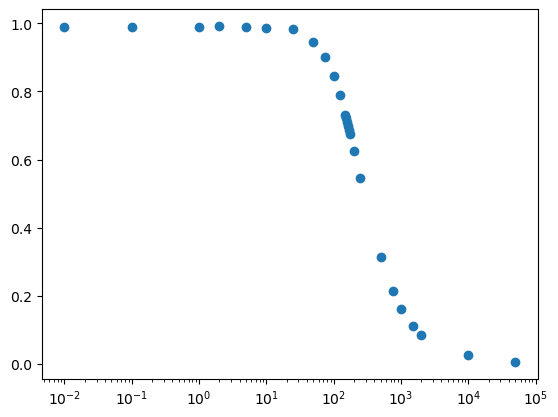

In [10]:
freqs = []
ampiezze = []
for (f, (t, ch1, ch2, _)) in files1mod:
    freqs.append(f)
    Vin = np.nanmax(ch1) - np.nanmin(ch1)
    Vout = np.nanmax(ch2) - np.nanmin(ch2)
    Vout_Vin = Vout / Vin
    ampiezze.append(Vout_Vin)

plt.scatter(freqs, ampiezze)
plt.xscale("log")

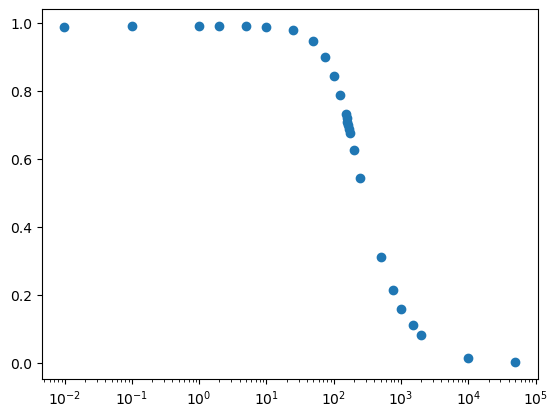

In [11]:
freqs = []
ampiezze = []
for (_, t, sine1, sine2) in files1fit:
    freqs.append(sine1.freq)
    Vin = sine1.ampl
    Vout = sine2.ampl
    Vout_Vin = Vout / Vin
    ampiezze.append(Vout_Vin)

plt.scatter(freqs, ampiezze)
plt.xscale("log")

$$\varphi = - \arctan\left(\omega \tau\right)$$

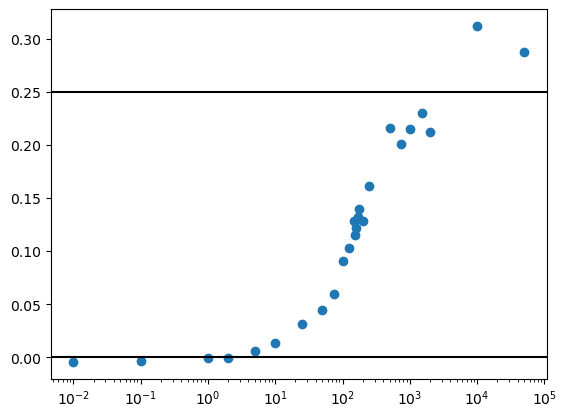

In [12]:
freqs: list[float] = []
fasi: list[float] = []
for (f, (t, ch1, ch2, _)) in files1mod:
    freqs.append(f)
    fase: float = (t[np.nanargmax(ch1)] - t[np.nanargmax(ch2)]) * f
    while fase > 0.5: fase -= 1
    if fase < -1: fase += 1
    fasi.append(-fase)

plt.scatter(freqs, fasi)
plt.xscale("log")
plt.hlines([0, .25], *plt.xlim(), color="k")

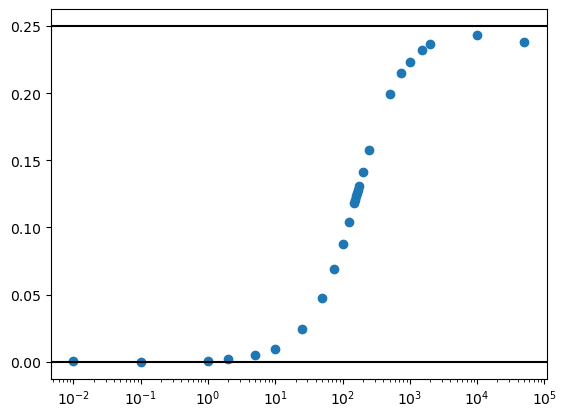

In [13]:
freqs: list[float] = []
fasi: list[float] = []
for (_, t, sine1, sine2) in files1fit:
    freqs.append(sine1.freq)
    fase = sine1.phase - sine2.phase
    # while fase > 0.5: fase -= 1
    # if fase < -1: fase += 1
    fasi.append(fase / (2 * np.pi))

plt.scatter(freqs, fasi)
plt.xscale("log")
plt.hlines([0, .25], *plt.xlim(), color="k")

2.464e-05 -9.62e-06
∆t = -3.426e-05
T = 2e-05
fase = -1.713


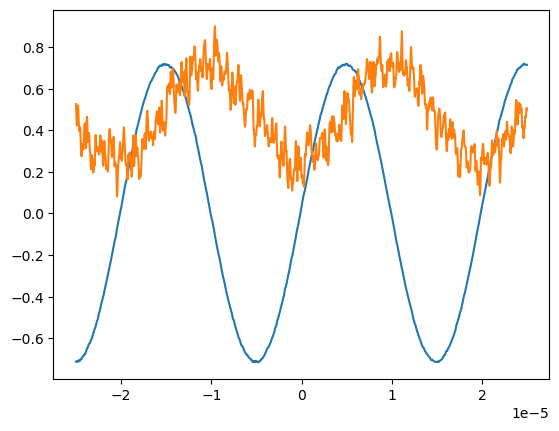

In [14]:
(f, (t, ch1, ch2mod, _)) = files1mod[19]
plt.plot(t, ch1)
plt.plot(t, ch2mod * 100)
t1: float; t2: float
fase: float = ((t2 := t[np.nanargmax(ch2mod)]) - (t1 := t[np.nanargmax(ch1)])) * f
print(t1, t2)
print("∆t =", t2 - t1)
print("T =", 1 / f)
print("fase =", fase)

# Seconda parte

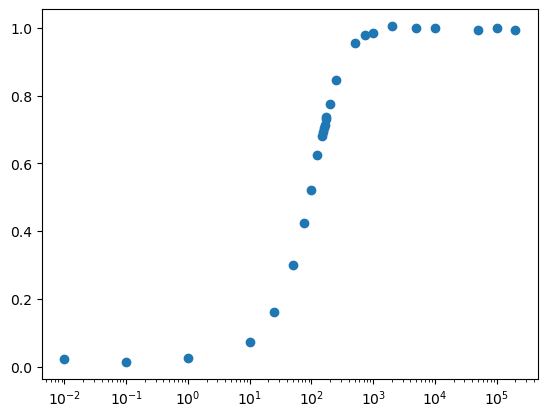

In [15]:
freqs = []
ampiezze = []
for (f, (t, ch1, ch2, _)) in files2:
    freqs.append(f)
    Vin = np.nanmax(ch1) - np.nanmin(ch1)
    Vout = np.nanmax(ch2) - np.nanmin(ch2)
    Vout_Vin = Vout / Vin
    ampiezze.append(Vout_Vin)

plt.scatter(freqs, ampiezze)
plt.xscale("log")

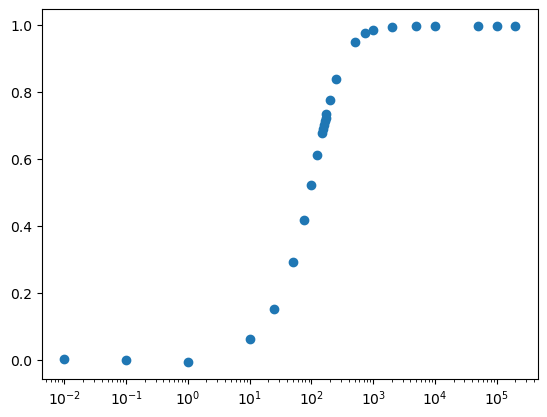

In [16]:
freqs = []
ampiezze = []
for (_, t, sine1, sine2) in files2fit:
    freqs.append(sine1.freq)
    Vin = sine1.ampl
    Vout = sine2.ampl
    Vout_Vin = Vout / Vin
    ampiezze.append(Vout_Vin)

plt.scatter(freqs, ampiezze)
plt.xscale("log")

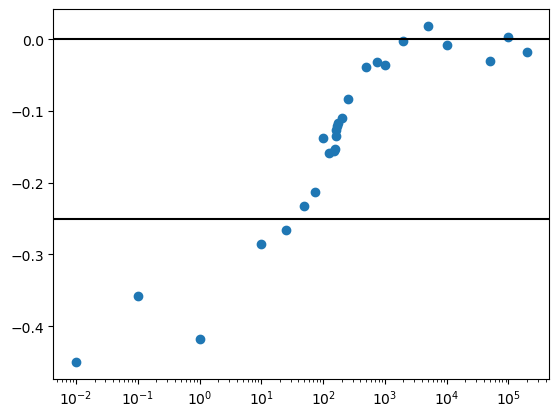

In [17]:
freqs: list[float] = []
fasi: list[float] = []
for (f, (t, ch1, ch2, _)) in files2:
    freqs.append(f)
    fase: float = (t[np.nanargmax(ch1)] - t[np.nanargmax(ch2)]) * f
    if fase < -0.5:
        fase += 1
    fasi.append(-fase)

plt.scatter(freqs, fasi)
plt.xscale("log")
plt.hlines([0, -.25], *plt.xlim(), color="k")

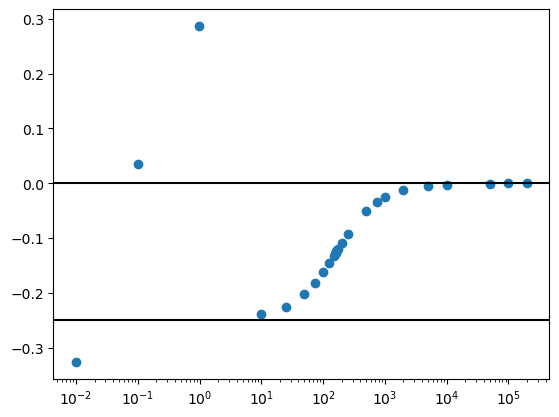

In [18]:
freqs: list[float] = []
fasi: list[float] = []
for (_, t, sine1, sine2) in files2fit:
    freqs.append(sine1.freq)
    fase = (sine1.phase - sine2.phase) / (2 * np.pi)
    # while fase > 0: fase -= 1
    # if fase < -1: fase += 1
    fasi.append(fase)

plt.scatter(freqs, fasi)
plt.xscale("log")
plt.hlines([0, -.25], *plt.xlim(), color="k")

# Altro